In [74]:
import glob, os
import pandas as pd
import csv
import dateutil.parser
%matplotlib inline
import matplotlib
import datetime
import calendar
import calendar
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

# Preprocessing

##Read files

In [75]:
data_path = "data/"
allFiles = [file for file in glob.glob(data_path+"*.txt")]

In [76]:
df_list=[pd.read_csv(f) for f in allFiles]
df=pd.concat(df_list)

In [77]:
df.rename(columns=lambda x: x.strip(),inplace=True)

In [78]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,REGULAR,5106835,1729680
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,REGULAR,5106961,1729784
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,REGULAR,5107250,1729858


## Date parsing

In [79]:
#create 2 new columns in df 'date_time' and 'date_parsed'
df['date_time'] = pd.to_datetime(df.DATE + ' ' + df.TIME)
df['date_parsed'] = pd.to_datetime(df.DATE)

##Sort the entries

In [80]:
df=df.sort(['C/A','UNIT','SCP','STATION','LINENAME','DIVISION','date_time'])

## Get non cummulative count

Since its Already sorted...
lets create a syntetic key by C/A, Unit,SCP,Station

In [81]:
df['key']= tuple(zip(df['C/A'],df['UNIT'],df['SCP'],df['STATION']))

Lets shift the entries,exits and count

In [83]:
df.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,date_parsed,key
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635,2015-04-25 00:00:00,2015-04-25,"(A002, R051, 02-00-00, LEXINGTON AVE)"
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649,2015-04-25 04:00:00,2015-04-25,"(A002, R051, 02-00-00, LEXINGTON AVE)"


In [84]:
df['shifted_entries']=df['ENTRIES'].shift(periods=1) 
df['shifted_exits']=df['EXITS'].shift(periods=1) 
df['shifted_key']=df['key'].shift(periods=1) 

Subtract from previous if the key is the same

In [85]:
df['ENTRIESn_hourly'] = np.where(df['shifted_key']==df['key'],df['ENTRIES']-df['shifted_entries'],0)
df['EXITSn_hourly'] = np.where(df['shifted_key']==df['key'],df['EXITS']-df['shifted_exits'],0)

The counter might have resetted to 0....lets just skip those rows

In [86]:
min_bad_value=0
max_bad_value=10000

In [87]:
bad_values=df[(df.ENTRIESn_hourly<min_bad_value) | (df.ENTRIESn_hourly>max_bad_value)]
good_values=df[(df.ENTRIESn_hourly>=min_bad_value) & (df.ENTRIESn_hourly<=max_bad_value)]
print ("There are %s bad values and %s good values"%(len(bad_values),len(good_values)))

There are 5419 bad values and 955431 good values


lets save the results and remove miscellaneous columns

In [88]:
df.drop(['shifted_entries','shifted_exits','shifted_key'],inplace=True,axis=1)
df=good_values

## Filter dates for only month of may

In [89]:
#filters date to May 2015
earliest_may_date=datetime.date(2015,5,1)
latest_may_date=datetime.date(2015,5,30)
may_df=df[(df.date_parsed >= earliest_may_date) & (df.date_parsed <= latest_may_date)]
print ("There were %s entries"%(len(df)))
print ("There are %s entries in month of may. So we lost %s entires"%(len(may_df) , len(df)-len(may_df)))

df=may_df

There were 955431 entries
There are 791432 entries in month of may. So we lost 163999 entires


## Total 

In [90]:
df=df.copy()
df['total_traffic'] = df.ENTRIESn_hourly + df.EXITSn_hourly

## Filter weekday and weekend

Moday is 0
Saturday is 5

In [91]:
#filter weekdays only
weekday_date_df=df[df['date_parsed'].dt.weekday < 5]
weekend_date_df=df[df['date_parsed'].dt.weekday >= 5]
#df[df['date_parsed'].dt.weekday < 5].tail(50)

# Top weekday entries and exits

In [100]:
wday_entries_exits=weekday_date_df[['STATION','ENTRIESn_hourly','EXITSn_hourly']].groupby(['STATION']).agg({'EXITSn_hourly':sum,'ENTRIESn_hourly':sum})
wday_entries_exits=wday_entries_exits.reset_index()

wday_entries_exits=wday_entries_exits.sort('EXITSn_hourly',ascending=False)
wday_entries_exits.rename(columns={'ENTRIESn_hourly':'entries', 'EXITSn_hourly':'exits'}, inplace=True)

wday_entries_exits=wday_entries_exits.reset_index(drop=True)
top_weekday_stations = wday_entries_exits.head(10)
top_weekday_stations

,STATION,entries,exits
0,34 ST-PENN STA,3745056,3194079
1,42 ST-GRD CNTRL,3275331,3031273
2,34 ST-HERALD SQ,2580463,2317637
3,14 ST-UNION SQ,2308018,2047197
4,86 ST,2429077,1870693
5,42 ST-TIMES SQ,2112047,1864992
6,42 ST-PA BUS TE,1947096,1478327
7,FULTON ST,1675386,1442471
8,47-50 ST-ROCK,1276318,1343816
9,125 ST,1671846,1330222


#Top weekend entries and exits

In [101]:
weekend_entries_exits=weekend_date_df[['STATION','ENTRIESn_hourly','EXITSn_hourly']].groupby(['STATION']).agg({'EXITSn_hourly':sum,'ENTRIESn_hourly':sum})
weekend_entries_exits=weekend_entries_exits.reset_index()

weekend_entries_exits=weekend_entries_exits.sort('EXITSn_hourly',ascending=False)
weekend_entries_exits.rename(columns={'ENTRIESn_hourly':'entries', 'EXITSn_hourly':'exits'}, inplace=True)

weekend_entries_exits = weekend_entries_exits.reset_index(drop=True)

top_weekend_stations = weekend_entries_exits.head(10)
top_weekend_stations

,STATION,entries,exits
0,34 ST-PENN STA,711723,649478
1,14 ST-UNION SQ,591556,541195
2,34 ST-HERALD SQ,559391,499624
3,42 ST-TIMES SQ,549151,490742
4,86 ST,549964,455201
5,42 ST-GRD CNTRL,468558,445326
6,42 ST-PA BUS TE,507479,415759
7,125 ST,417512,372082
8,CANAL ST,388155,317872
9,59 ST-COLUMBUS,384631,294297


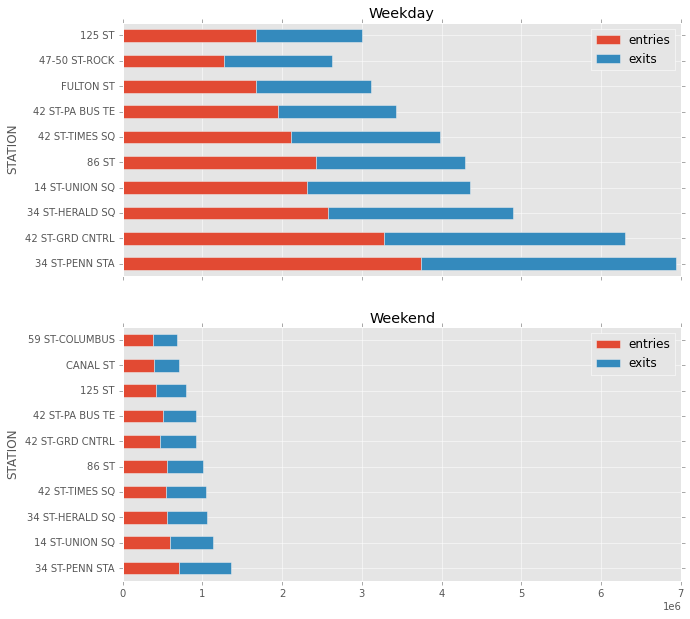

In [102]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

top_weekday_stations.plot('STATION',kind='barh',stacked=True,ax=ax1);
#ax1.set_title('Total Ridership for the Month of May on weekday')
ax1.set_title('Weekday')


top_weekend_stations.plot('STATION',kind='barh',stacked=True,ax=ax2);
ax2.set_title('Weekend')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))



In [103]:
merged_tally=weekend_entries_exits.merge(wday_entries_exits,on='STATION')
merged_tally.head()

,STATION,entries_x,exits_x,entries_y,exits_y
0,34 ST-PENN STA,711723,649478,3745056,3194079
1,14 ST-UNION SQ,591556,541195,2308018,2047197
2,34 ST-HERALD SQ,559391,499624,2580463,2317637
3,42 ST-TIMES SQ,549151,490742,2112047,1864992
4,86 ST,549964,455201,2429077,1870693


# Top in the hours

Valid time ranges

In [104]:
valid_time_ranges=['00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00']

sum across all turnstile for a station 

In [105]:
avg_wkday_entries= weekday_date_df[['STATION','DATE','TIME','ENTRIESn_hourly']].groupby(['STATION','DATE','TIME']).agg({'ENTRIESn_hourly':np.sum})
avg_wkday_entries=avg_wkday_entries.reset_index()

filter invalid time ranges

In [106]:
avg_wkday_entries = avg_wkday_entries[avg_wkday_entries['TIME'].isin(valid_time_ranges)]

compute median across all time blocks for all stations

In [107]:
avg_wkday_entries= avg_wkday_entries[['STATION','TIME','ENTRIESn_hourly']].groupby(['STATION','TIME']).agg({'ENTRIESn_hourly':np.median})
avg_wkday_entries=avg_wkday_entries.reset_index()

avg_wkday_entries = avg_wkday_entries [avg_wkday_entries['STATION'].isin(top_station_names)]

avg_wkday_entries.rename(columns={'ENTRIESn_hourly':'entries'}, inplace=True)




pivot by station

In [109]:
avg_wkday_entries_pivot=avg_wkday_entries.pivot(index='TIME', columns='STATION', values='entries')
avg_wkday_entries_pivot.head()

STATION,125 ST,34 ST-HERALD SQ,34 ST-PENN STA,42 ST-GRD CNTRL,42 ST-PA BUS TE,42 ST-TIMES SQ,59 ST-COLUMBUS,86 ST,CANAL ST
TIME,,,,,,,,,
00:00:00,4369,18183,12915,9408,5233,21311,13294,9572,2801
04:00:00,699,2103,1680,1287,616,3759,1671,894,330
08:00:00,4546,6594,17208,5860,13605,5038,2459,10445,531
12:00:00,9970,22330,37102,16731,19783,13426,11125,26028,2206
16:00:00,8662,23652,20491,14036,7652,17732,18626,19158,4326


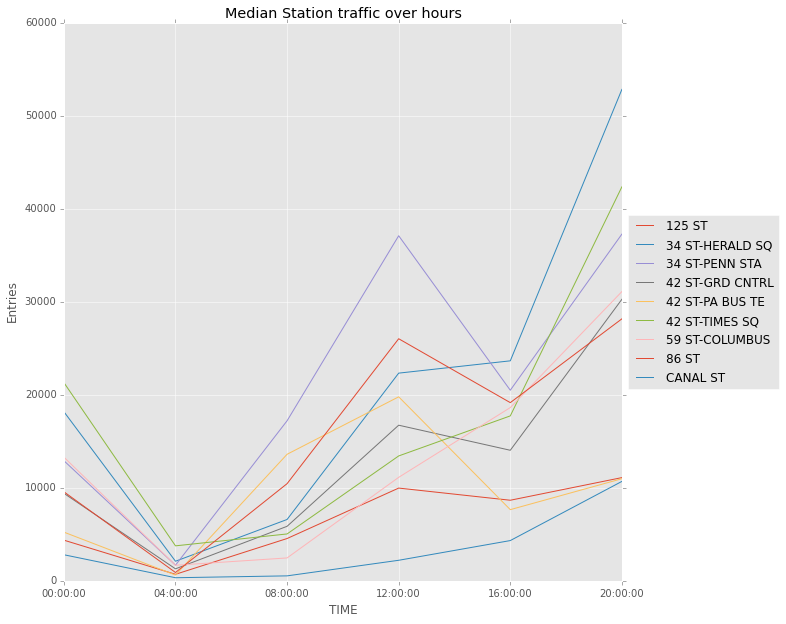

In [110]:
avg_wkday_entries_pivot.plot()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Entries')
plt.title('Median Station traffic over hours')